In [38]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch

seed=61

import random
random.seed(seed)
np.random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

LABELS = 5
TRAIN_EPOCHS = 6
VAL_SPLIT = 0.1
MAX_TOKENS = 40
BATCH_SIZE = 120

base_path = '/kaggle/input/nitro-our-dataset'
train_df = pd.read_csv(f'{base_path}/train_data.csv')
test_df = pd.read_csv(f'{base_path}/test_data.csv')

URL_REGEX = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
TWITTER_HANDLE_REGEX = r'@[a-zA-Z0-9_-]+'
NUMBER_REGEX = r"\d+"

train_df = train_df.drop(train_df[train_df['Text'].str.contains('\t')].index)

def sanitize_cedilla(df):
    df['Text'] = df['Text'] \
        .str.replace("ţ", "ț") \
        .str.replace("ş", "ș") \
        .str.replace("Ţ", "Ț") \
        .str.replace("Ş", "Ș")
    return df

train_df['Text'] = train_df['Text'].str.replace(URL_REGEX, ' ', regex=True)
train_df['Text'] = train_df['Text'].str.replace(TWITTER_HANDLE_REGEX, ' ', regex=True)
train_df['Text'] = train_df['Text'].str.replace(NUMBER_REGEX, ' ', regex=True)
train_df['Text'] = train_df['Text'].str.replace(r'\s+', ' ', regex=True)
train_df = sanitize_cedilla(train_df)

test_df['Text'] = test_df['Text'].str.replace(URL_REGEX, ' ', regex=True)
test_df['Text'] = test_df['Text'].str.replace(TWITTER_HANDLE_REGEX, ' ', regex=True)
test_df['Text'] = test_df['Text'].str.replace(NUMBER_REGEX, ' ', regex=True)
test_df['Text'] = test_df['Text'].str.replace(r'\s+', ' ', regex=True)
test_df = sanitize_cedilla(test_df)

In [31]:
train_df['Text Len'] = train_df['Text'].str.len()

In [32]:
train_df.groupby('Final Labels')['Text Len'].mean()

Final Labels
descriptive      113.907285
direct            58.100875
non-offensive    109.085864
offensive        115.800416
reporting        176.686364
Name: Text Len, dtype: float64

In [33]:
train_df.groupby('Final Labels')['Text Len'].median()

Final Labels
descriptive       90.5
direct            45.0
non-offensive     86.0
offensive         89.0
reporting        173.0
Name: Text Len, dtype: float64

In [39]:
# train_df[train_df['Final Labels'] == 'descriptive'][:100]['Text'].tolist()

In [2]:
from transformers import MT5EncoderModel, T5Tokenizer, AutoConfig
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'
tokenizer = T5Tokenizer.from_pretrained("dumitrescustefan/mt5-base-romanian")

In [3]:
!pip install pytictoc
from pytictoc import TicToc

In [4]:
t = TicToc()
t.tic()
tokenized_sentences = tokenizer(train_df['Text'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=MAX_TOKENS)
t.toc()

Elapsed time is 8.512053 seconds.


In [5]:
tokenized_sentences['input_ids'][0]

tensor([  6510,   4560,    703,    480,   2331,    728,    259,  54182,    270,
          4767,    302,    259,    260,    260,  90635,  90635,    260,    260,
          1464,  66114,    259,  73486,   4394,    259,  72329, 239199,      1,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0])

In [6]:
mt5_default = MT5EncoderModel.from_pretrained("dumitrescustefan/mt5-base-romanian")

You are using a model of type t5 to instantiate a model of type mt5. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at dumitrescustefan/mt5-base-romanian were not used when initializing MT5EncoderModel: ['decoder.block.6.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.3.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.5.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.q.weight', 'decoder.block.10.layer.2.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.5.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.3.layer.1.layer_norm.weight', 'decoder.block.6.layer.2.layer_norm.weight', 'decoder.block.1.layer.1.EncDecAttention.k.weight', 'decoder.block.6.layer.2.DenseReluDense.wo.weight', 'decoder.block.4.layer.1.EncDecAttention.k.weight', 'decoder.block.8.layer.1.EncDecAttention.k.weight', 'decoder.block.4.layer.1.EncDecAttention.o.weight', 'decoder.block.4.lay

In [7]:
to_unfreeze = [
"encoder.block.8.layer.0.SelfAttention.q.weight",
"encoder.block.8.layer.0.SelfAttention.k.weight",
"encoder.block.8.layer.0.SelfAttention.v.weight",
"encoder.block.8.layer.0.SelfAttention.o.weight",
"encoder.block.8.layer.0.layer_norm.weight",
"encoder.block.8.layer.1.DenseReluDense.wi_0.weight",
"encoder.block.8.layer.1.DenseReluDense.wi_1.weight",
"encoder.block.8.layer.1.DenseReluDense.wo.weight",
"encoder.block.8.layer.1.layer_norm.weight",
"encoder.block.9.layer.0.SelfAttention.q.weight",
"encoder.block.9.layer.0.SelfAttention.k.weight",
"encoder.block.9.layer.0.SelfAttention.v.weight",
"encoder.block.9.layer.0.SelfAttention.o.weight",
"encoder.block.9.layer.0.layer_norm.weight",
"encoder.block.9.layer.1.DenseReluDense.wi_0.weight",
"encoder.block.9.layer.1.DenseReluDense.wi_1.weight",
"encoder.block.9.layer.1.DenseReluDense.wo.weight",
"encoder.block.9.layer.1.layer_norm.weight",
"encoder.block.10.layer.0.SelfAttention.q.weight",
"encoder.block.10.layer.0.SelfAttention.k.weight",
"encoder.block.10.layer.0.SelfAttention.v.weight",
"encoder.block.10.layer.0.SelfAttention.o.weight",
"encoder.block.10.layer.0.layer_norm.weight",
"encoder.block.10.layer.1.DenseReluDense.wi_0.weight",
"encoder.block.10.layer.1.DenseReluDense.wi_1.weight",
"encoder.block.10.layer.1.DenseReluDense.wo.weight",
"encoder.block.10.layer.1.layer_norm.weight",
"encoder.block.11.layer.0.SelfAttention.q.weight",
"encoder.block.11.layer.0.SelfAttention.k.weight",
"encoder.block.11.layer.0.SelfAttention.v.weight",
"encoder.block.11.layer.0.SelfAttention.o.weight",
"encoder.block.11.layer.0.layer_norm.weight",
"encoder.block.11.layer.1.DenseReluDense.wi_0.weight",
"encoder.block.11.layer.1.DenseReluDense.wi_1.weight",
"encoder.block.11.layer.1.DenseReluDense.wo.weight",
"encoder.block.11.layer.1.layer_norm.weight",
"encoder.final_layer_norm.weight"
]

In [8]:
for (name, param) in mt5_default.named_parameters():
    if name in to_unfreeze:
        print(name)
        param.requires_grad = True

encoder.block.8.layer.0.SelfAttention.q.weight
encoder.block.8.layer.0.SelfAttention.k.weight
encoder.block.8.layer.0.SelfAttention.v.weight
encoder.block.8.layer.0.SelfAttention.o.weight
encoder.block.8.layer.0.layer_norm.weight
encoder.block.8.layer.1.DenseReluDense.wi_0.weight
encoder.block.8.layer.1.DenseReluDense.wi_1.weight
encoder.block.8.layer.1.DenseReluDense.wo.weight
encoder.block.8.layer.1.layer_norm.weight
encoder.block.9.layer.0.SelfAttention.q.weight
encoder.block.9.layer.0.SelfAttention.k.weight
encoder.block.9.layer.0.SelfAttention.v.weight
encoder.block.9.layer.0.SelfAttention.o.weight
encoder.block.9.layer.0.layer_norm.weight
encoder.block.9.layer.1.DenseReluDense.wi_0.weight
encoder.block.9.layer.1.DenseReluDense.wi_1.weight
encoder.block.9.layer.1.DenseReluDense.wo.weight
encoder.block.9.layer.1.layer_norm.weight
encoder.block.10.layer.0.SelfAttention.q.weight
encoder.block.10.layer.0.SelfAttention.k.weight
encoder.block.10.layer.0.SelfAttention.v.weight
encoder.bl

In [9]:
label_to_int = {
            'direct': 0,
            'descriptive': 1,
            'reporting': 2,
            'non-offensive': 3,
            'offensive': 4,
}

train_df['labels'] = train_df['Final Labels'].map(label_to_int)
labels_encoded = train_df['labels'].to_numpy()

In [10]:
weight = 1 - np.unique(labels_encoded, return_counts=True)[1] / len(labels_encoded)
weight = torch.from_numpy(weight).type(torch.float).to(device)

In [11]:
class MT5Dataset(torch.utils.data.Dataset):
    def __init__(self, tokenized, labels = None):
        self.tokenized = tokenized
        self.labels = labels
    
    def __getitem__(self, index):
        item = {
            'input_ids': self.tokenized['input_ids'][index],
            'attention_mask': self.tokenized['attention_mask'][index],
        }
        if self.labels is not None:
            item['labels'] = self.labels[index]
        return item

    def __len__(self):
        return len(self.tokenized['input_ids'])

class MyMT5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.mt5 = mt5_default
        self.fc_head = torch.nn.Linear(MAX_TOKENS * 768, LABELS)
    def forward(self, input_ids, attention_mask):
        y = self.mt5(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        y = y.view(y.shape[0], -1)
        y = self.fc_head(y)
        return y
    
model = MyMT5()

In [12]:
from sklearn.model_selection import train_test_split

X_train_ids, X_test_ids, y_train, y_test = train_test_split(tokenized_sentences['input_ids'], labels_encoded, test_size=VAL_SPLIT, random_state=42, stratify=labels_encoded)
X_train_attention, X_test_attention, y_train_2, y_test_2 = train_test_split(tokenized_sentences['attention_mask'], labels_encoded, test_size=VAL_SPLIT, random_state=42, stratify=labels_encoded)
assert y_train[67] == y_train_2[67]

In [13]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.1 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.0/546.0 kB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [14]:
X_train = {
    'input_ids': X_train_ids,
    'attention_mask': X_train_attention,
}

X_test = {
    'input_ids': X_test_ids,
    'attention_mask': X_test_attention,
}

In [15]:
train_dataset = MT5Dataset(X_train, labels=y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MT5Dataset(X_test, labels=y_test)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)


In [16]:
import lightning.pytorch as pl
from sklearn.metrics import balanced_accuracy_score

class LightingModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def training_step(self, batch, batch_idx):
        y = batch['labels']
        y_hat = self.model(batch['input_ids'], batch['attention_mask'])
        
        loss = torch.nn.functional.cross_entropy(y_hat, y, weight=weight)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        y = batch['labels']
        y_hat = self.model(batch['input_ids'], batch['attention_mask'])
        
        loss = torch.nn.functional.cross_entropy(y_hat, y, weight=weight)
        self.log("val_loss", loss, prog_bar=True)
        
        y_hat_class = torch.argmax(y_hat, dim=1).cpu()
        y = y.cpu()
        acc = balanced_accuracy_score(y, y_hat_class)
        
        self.log("val_acc", acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        y = batch['labels']
        y_hat = self.model(batch['input_ids'], batch['attention_mask'])
        
        loss = torch.nn.functional.cross_entropy(y_hat, y, weight=weight)
        
        y_hat_class = torch.argmax(y_hat, dim=1).cpu()
        y = y.cpu()
        acc = balanced_accuracy_score(y, y_hat_class)
        
        self.log("test_loss", loss)
        self.log("test_acc", acc)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        return optimizer

In [17]:
mymodule = LightingModule(model)
trainer = pl.Trainer(max_epochs=TRAIN_EPOCHS, accelerator="gpu")
trainer.fit(mymodule, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type  | Params
--------------------------------
0 | model | MyMT5 | 277 M 
--------------------------------
277 M     Trainable params
0         Non-trainable params
277 M     Total params
1,108.775 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_clas

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_clas

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_clas

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_clas

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_clas

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_clas

In [18]:
trainer.logged_metrics

{'train_loss': tensor(0.2671),
 'val_loss': tensor(0.2714),
 'val_acc': tensor(0.9060, dtype=torch.float64)}

In [19]:
trainer.test(mymodule, dataloaders=val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_clas

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.906026622748851     │
│         test_loss         │     0.271431565284729     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.271431565284729, 'test_acc': 0.906026622748851}]

In [20]:
test_tokenized_sentences = tokenizer(test_df['Text'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=MAX_TOKENS)

test_dataset = MT5Dataset(test_tokenized_sentences)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
mymodule.model.eval()
mymodule.model.to(device)
predictions = []
for batch in test_loader:
    y_hat = mymodule.model(batch['input_ids'].to(device), batch['attention_mask'].to(device))        
    y_hat_class = torch.argmax(y_hat, dim=1).cpu()
    predictions.append(y_hat_class)

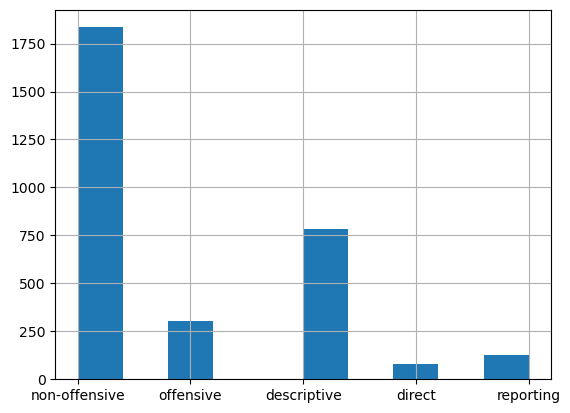

In [22]:
results = []
for p in predictions:
    results.extend(p.tolist())
sample = pd.read_csv(f'{base_path}/sample_submission.csv')
sample['Label'] =  results


int_to_label = {
            0: 'direct',
            1:'descriptive',
            2:'reporting',
            3:'non-offensive',
            4:'offensive',
}
sample['Label'] = sample['Label'].map(int_to_label)

sample['Label'].hist()

sample.to_csv('submission.csv', index=False)